In [1]:
import numpy as np
from numba import njit
from scipy import sparse, linalg
from scipy.io import mmread, mmwrite
from adaptive_step_DMM_sqrt import CAdaptiveDMMsqrt
from adaptive_C_sqrt import CAdaptive_C_RK4_sqrt
from adaptive_GC_sqrt import CAdaptive_GC_RK4_sqrt
import matplotlib.pyplot as plt
import time

In [2]:
def c_get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    coeff = 2 * num_electrons / S.trace() * S
    return coeff @ linalg.funm(inv_S @ H, 
                    lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

def gc_get_exact(H, S, num_electrons, beta, mu):
    inv_S = linalg.inv(S)
    return S @ linalg.funm(inv_S @ H,
                lambda _: np.exp(-beta * (_ - mu)) / (1 + np.exp(-beta * (_ - mu))))

def propagate_each(class_list, final_beta):
    for _ in class_list:
        _.propagate(final_beta)
        
def plot_eigs(class_list, ferm_exact, E, S, filename):
    plt.plot(E, linalg.eigvalsh(ferm_exact, S)[::-1], 'ks-', label='Exact')
    for _ in class_list:
        plt.plot(E, linalg.eigvalsh(_.rho, S)[::-1], label='tol=' + str(_.tol))
    plt.legend(numpoints=1)
    plt.savefig(filename, format='png', dpi=300)
    
def get_norm_diffs(class_list, ferm_exact):
    return [(_.tol, linalg.norm(ferm_exact - _.rho)) for _ in class_list]
    

In [3]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# Define path for matrices
matrices_path = "larger_matrices/"

# 16 atom supercell

In [5]:
# Define path to H and S matrices
H_16 = mmread(matrices_path + "16_H.mtx").toarray()
S_16 = mmread(matrices_path + "16_S.mtx").toarray()

E, V = linalg.eigh(H_16, S_16)

# Define num_electrons and beta
num_electrons = 32
beta = 100
dbeta = 0.01

# Define chemical potential
core_spec = linalg.eigvalsh(H_16, S_16)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

# Define tolerances to use
tols = [0, 1e-6, 1e-5, 1e-4, 1e-3]

## Canonical

In [6]:
c_16_list = [CAdaptive_C_RK4_sqrt(ovlp=S_16, H=H_16, num_electrons=num_electrons, dbeta=dbeta, 
                                 epsilon=1e-3, tol=_) for _ in tols]
propagate_each(c_16_list, beta)

Energy_next > energy


Energy_next > energy


In [7]:
c_fd_16 = c_get_exact(H_16, S_16, num_electrons, beta, c_16_list[0].mu)

funm result may be inaccurate, approximate err = 1


In [8]:
H_16.shape[0]

144

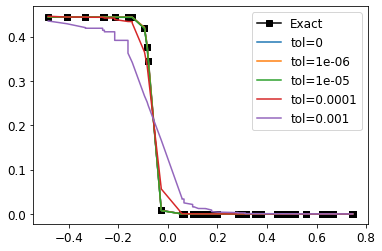

In [9]:
filename = "larger_matrices/sqrt_figs/c_rk4_sparsity_eps=1e-3.png"
plot_eigs(c_16_list, c_fd_16, E, S_16, filename)

In [10]:
get_norm_diffs(c_16_list, c_fd_16)

[(0, 0.02197601137780897),
 (1e-06, 0.02031699204281192),
 (1e-05, 0.010731059373632217),
 (0.0001, 0.28410093859338453),
 (0.001, 1.0583647568489645)]

0.5570987654320988


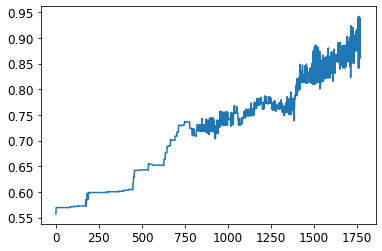

In [11]:
plt.plot(c_16_list[4].sparsity)
print(min(c_16_list[4].sparsity))

## Grand Canonical

In [10]:
gc_16_list = [CAdaptive_GC_RK4_sqrt(ovlp=S_16, H=H_16, mu=mu, dbeta=dbeta, 
                                 epsilon=1e-3, tol=_) for _ in tols]
propagate_each(gc_16_list, beta)

Energy_next > energy


In [11]:
gc_fd_16 = gc_get_exact(H_16, S_16, num_electrons, beta, mu)

funm result may be inaccurate, approximate err = 1


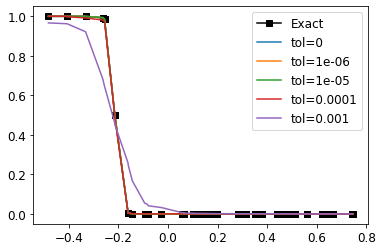

In [12]:
filename = "larger_matrices/sqrt_figs/gc_rk4_sparsity_eps=1e-3.png"
plot_eigs(gc_16_list, gc_fd_16, E, S_16, filename)

In [13]:
get_norm_diffs(gc_16_list, gc_fd_16)

[(0, 0.009178191603151259),
 (1e-06, 0.009280883041717083),
 (1e-05, 0.013293716482012241),
 (0.0001, 0.12701280729706393),
 (0.001, 2.723264660942467)]

# 54 atom supercell

In [14]:
# Define path to H and S matrices
H_54 = mmread(matrices_path + "54_H.mtx").toarray()
S_54 = mmread(matrices_path + "54_S.mtx").toarray()

E, V = linalg.eigh(H_54, S_54)

# Define num_electrons and beta
num_electrons = 108
beta = 100
dbeta = 0.01

# Define chemical potential
core_spec = linalg.eigvalsh(H_54, S_54)
index = int(num_electrons / 2)
mu = (core_spec[index] + core_spec[index - 1]) / 2

# Define tolerances to use
tols = [0, 1e-6, 1e-5, 1e-4, 1e-3]

## Canonical

In [15]:
c_54_list = [CAdaptive_C_RK4_sqrt(ovlp=S_54, H=H_54, num_electrons=num_electrons, dbeta=dbeta, 
                                 epsilon=1e-3, tol=_) for _ in tols]
propagate_each(c_54_list, beta)

Energy_next > energy


Energy_next > energy


In [16]:
c_fd_54 = c_get_exact(H_54, S_54, num_electrons, beta, c_54_list[0].mu)

funm result may be inaccurate, approximate err = 1


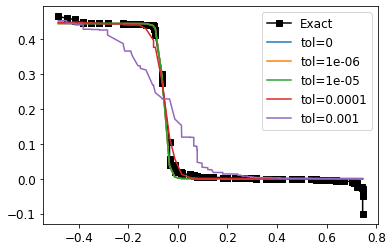

In [17]:
filename = "larger_matrices/sqrt_figs/c54_rk4_sparsity_eps=1e-3.png"
plot_eigs(c_54_list, c_fd_54, E, S_54, filename)

In [18]:
get_norm_diffs(c_54_list, c_fd_54)

[(0, 0.23395844950669004),
 (1e-06, 0.23393943929349634),
 (1e-05, 0.23478831002727382),
 (0.0001, 0.6746657597179911),
 (0.001, 2.5875857615255153)]

## Grand Canonical

In [19]:
gc_54_list = [CAdaptive_GC_RK4_sqrt(ovlp=S_54, H=H_54, mu=mu, dbeta=dbeta, 
                                 epsilon=1e-3, tol=_) for _ in tols]
propagate_each(gc_54_list, beta)

Energy_next > energy


Energy_next > energy


In [20]:
gc_fd_54 = gc_get_exact(H_54, S_54, num_electrons, beta, mu)

funm result may be inaccurate, approximate err = 1


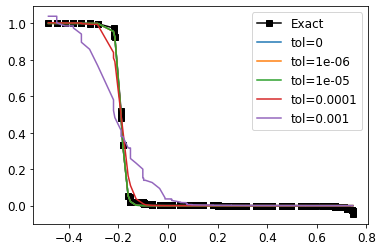

In [21]:
filename = "larger_matrices/sqrt_figs/gc54_rk4_sparsity_eps=1e-3.png"
plot_eigs(gc_54_list, gc_fd_54, E, S_54, filename)

In [22]:
get_norm_diffs(gc_54_list, gc_fd_54)

[(0, 0.17144752793884316),
 (1e-06, 0.17145228046426228),
 (1e-05, 0.17374911792228537),
 (0.0001, 1.3558939344599708),
 (0.001, 5.082511695736784)]